# All imports necessary

In [1]:
import sys
import warnings

In [2]:
sys.path.append('..')
warnings.filterwarnings("ignore")

In [3]:
from source.code.utils.utils import filter_by_subcorpus
from source.code.utils.utils import get_tagged_texts_as_pd

In [4]:
from source.code.utils.preprocessing import additional_features
from source.code.utils.preprocessing import iob3bio
from source.code.utils.preprocessing import filtrations

In [5]:
import os
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns

In [8]:
from tqdm.autonotebook import tqdm

In [9]:
import string

In [10]:
sns.set(color_codes=True)

In [11]:
sns.set(font_scale=2)

In [12]:
%matplotlib inline

# Read the data

## Where are we at the moment

In [13]:
! pwd

C:\Users\Efim_Golovin\Desktop\COURSES\ML\9. NLP\NLP\notebooks


In [14]:
! ls -alth ../data/datasets/gmb-2.2.0/

total 2.9G
-rw-rw-rw-    1 Efim_Golovin 0 2.7G 2018-11-10 20:48 en.tags.extracted.npy
drw-rw-rw-    4 Efim_Golovin 0 4.0K 2018-11-10 20:47 .
drw-rw-rw-    4 Efim_Golovin 0    0 2018-10-03 16:09 ..
-rw-rw-rw-    1 Efim_Golovin 0 179M 2018-09-27 17:32 en.tags.pd.extracted.csv
-rw-rw-rw-    1 Efim_Golovin 0  76M 2018-09-27 11:37 en.raw.extracted.npy
drw-rw-rw-  102 Efim_Golovin 0  12K 2018-09-24 13:22 data
-rw-rw-rw-    1 Efim_Golovin 0 7.4K 2014-07-04 16:12 README
-rw-rw-rw-    1 Efim_Golovin 0 2.0K 2014-07-04 16:06 NEWS
-rw-rw-rw-    1 Efim_Golovin 0  497 2014-07-02 17:09 THANKS
-rw-rw-rw-    1 Efim_Golovin 0  279 2014-06-23 15:24 LICENSE
drw-rw-rw-    2 Efim_Golovin 0    0 2013-08-21 15:16 doc


## Get the subset of folders for target subcorpus (Voice of America)

In [15]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

## Read subcorpus

Let's read the data and take a look at what's happening there:

In [16]:
tagged_texts_as_pd = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [19]:
tagged_texts_as_pd.head()

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr
0,Thousands,NNS,thousand,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1001]:pred(v1,thousand,n..."
1,of,IN,of,O,0,[],O,O,(NP\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
2,demonstrators,NNS,demonstrator,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1003]:pred(v1,demonstrat..."
3,have,VBP,have,O,0,[],O,O,(S[dcl]\NP)/(S[pt]\NP),"lam(v1,lam(v2,lam(v3,app(app(v1,v2),lam(v4,mer..."
4,marched,VBN,march,O,1,[Theme],O,O,S[pt]\NP,"lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[..."


In [18]:
tagged_texts_as_pd.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231279 entries, 0 to 1231278
Data columns (total 10 columns):
token                    1231279 non-null object
pos_tag                  1231279 non-null object
lemma                    1231279 non-null object
ner_tag                  1231279 non-null object
word_net_sense_number    1231279 non-null object
verb_net_roles           1231279 non-null object
semantic_relation        1231279 non-null object
animacy_tag              1231279 non-null object
super_tag                1227215 non-null object
lambda_dsr               1227215 non-null object
dtypes: object(10)
memory usage: 93.9+ MB


Let's take a look at what NER-tag we have:

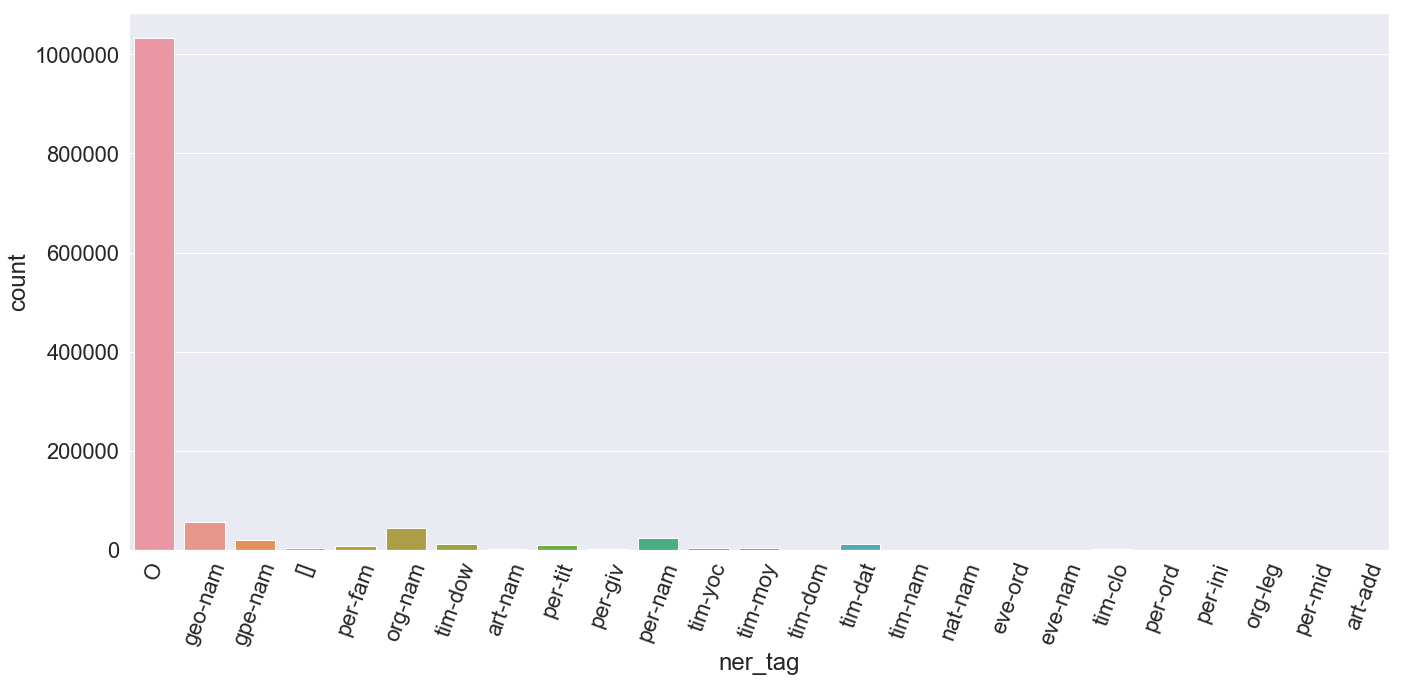

In [17]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

Too many 'O' tags.

Let's try to build a distribution without them:

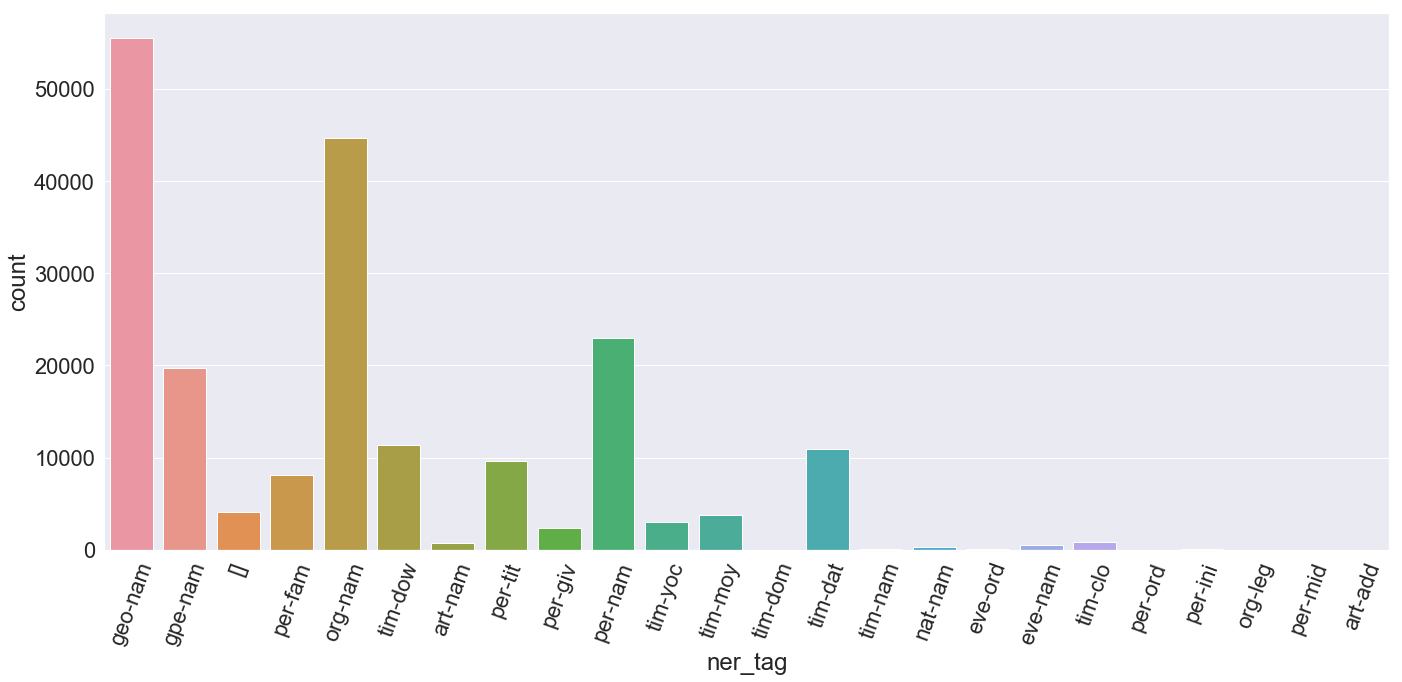

In [20]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

What is the '[]'?

Let's take a look at words whith this tag:

In [23]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].head()

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr
41,\tLQU\t,O,0,[],O,O,NP/NP,"lam(v1,v1)",NaN,NaN
46,\tRQU\t,O,0,[],O,O,NP\NP,"lam(v1,v1)",NaN,NaN
48,\tLQU\t,O,0,[],O,O,(S[dcl]\NP)/(S[dcl]\NP),"lam(v1,v1)",NaN,NaN
53,\tLQU\t,O,0,[],O,O,S[dcl]\S[dcl],"lam(v1,v1)",NaN,NaN
808,\tLQU\t,O,0,[],O,O,NP/NP,"lam(v1,v1)",NaN,NaN


In [22]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].token.value_counts()

\tLQU\t    3025
\tRQU\t    1039
Name: token, dtype: int64

In [21]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].pos_tag.value_counts()

O          3983
org-nam      37
per-nam      27
geo-nam      11
tim-dat       6
Name: pos_tag, dtype: int64

In [25]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].lemma.value_counts()

Series([], Name: lemma, dtype: int64)

Well, seems like it's just some trash.

It will be dropped out of the data in filtration function.

now let's just get rid of it here:

In [24]:
tagged_texts_as_pd = tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != '[]']

Let's also transform our tags into BIO-format:

In [26]:
tagged_texts_as_pd.ner_tag = iob3bio(tagged_texts_as_pd.ner_tag.values)

Okay, hot does it look like now:

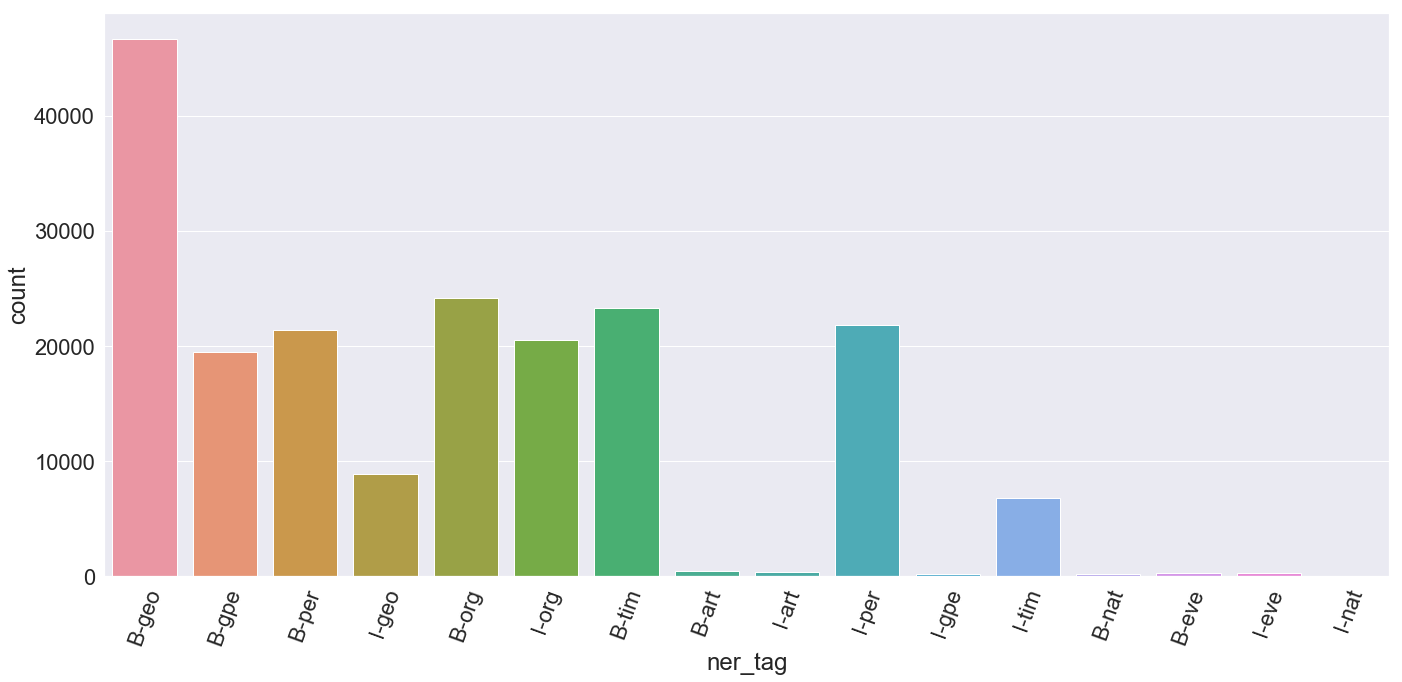

In [27]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

That looks pretty much better.

now let's look at tags with low number of words:

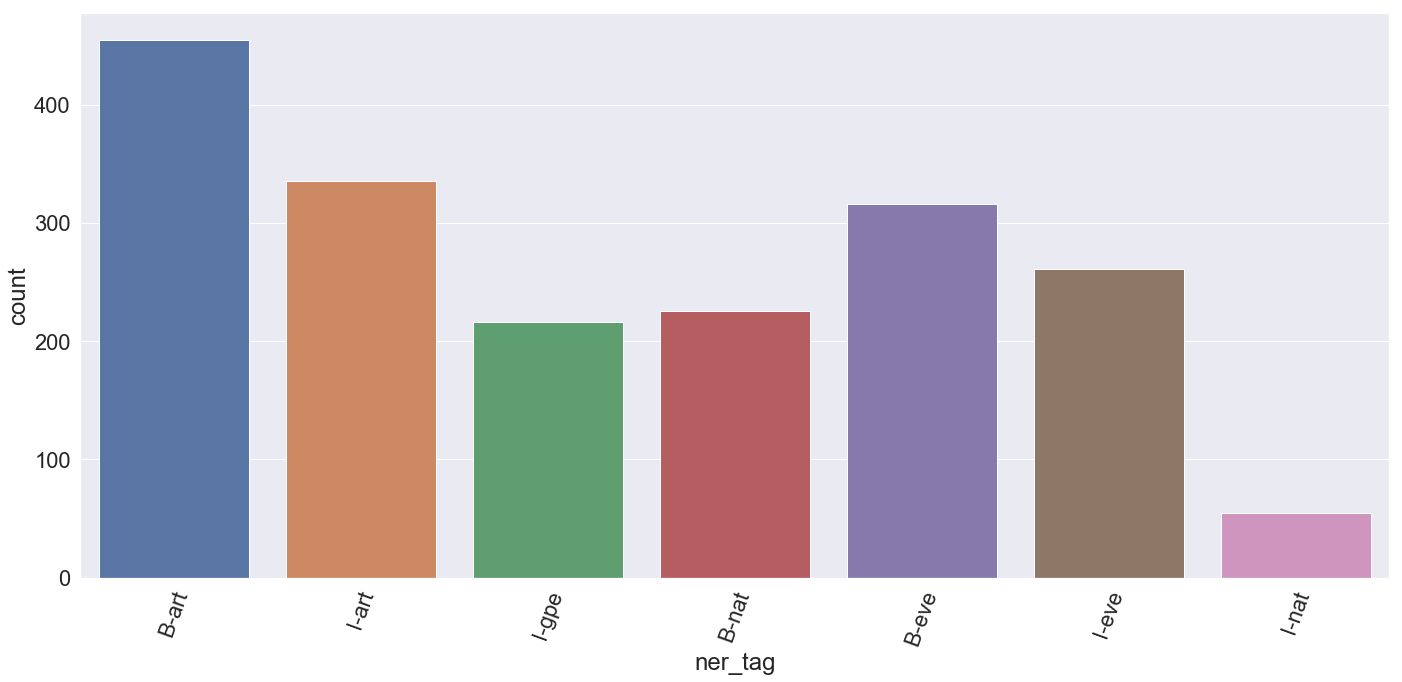

In [28]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag.isin(['B-art', 'I-art', 'I-gpe', 'B-nat', 'B-eve', 'I-eve', 'I-nat'])])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

As it can be seen there is not so much words with these tags.

Also we can notice that the number or GPE-entities composed from several words is very small.

# Tags count per each word

Here the idea is to look at how many tags can be assigned to some particular word.

In [30]:
tags_count_per_word_distribution = tagged_texts_as_pd.groupby('lemma')['ner_tag'].agg(lambda x: list(set(x))).reset_index().rename({'ner_tag': 'tags_list'}, axis=1)

In [31]:
tags_count_per_word_distribution['tags_count'] = tags_count_per_word_distribution.tags_list.apply(len)

In [32]:
tags_count_per_word_distribution.sort_values(by='tags_count', ascending=False).head(20)

,lemma,tags_list,tags_count
17879,of,"[I-geo, O, I-art, I-tim, I-gpe, I-org, I-eve, ...",11
10322,france,"[I-geo, B-per, B-art, O, B-org, I-org, I-art, ...",11
24471,the,"[I-geo, B-art, O, I-org, B-org, I-art, I-tim, ...",11
23412,state,"[I-geo, B-per, B-art, O, B-org, I-gpe, I-org, ...",10
18448,pakistan,"[I-geo, B-per, O, B-org, I-org, I-tim, B-gpe, ...",10
17356,new,"[I-geo, O, B-org, I-org, I-art, B-gpe, I-tim, ...",10
17984,olympics,"[I-geo, O, I-org, I-tim, B-org, I-eve, B-tim, ...",10
9044,england,"[I-geo, B-per, I-org, B-org, I-tim, B-gpe, I-e...",10
14,-,"[I-geo, B-per, O, I-org, I-tim, B-org, I-art, ...",10
15319,madrid,"[I-geo, O, I-org, I-tim, B-org, B-tim, B-geo, ...",9


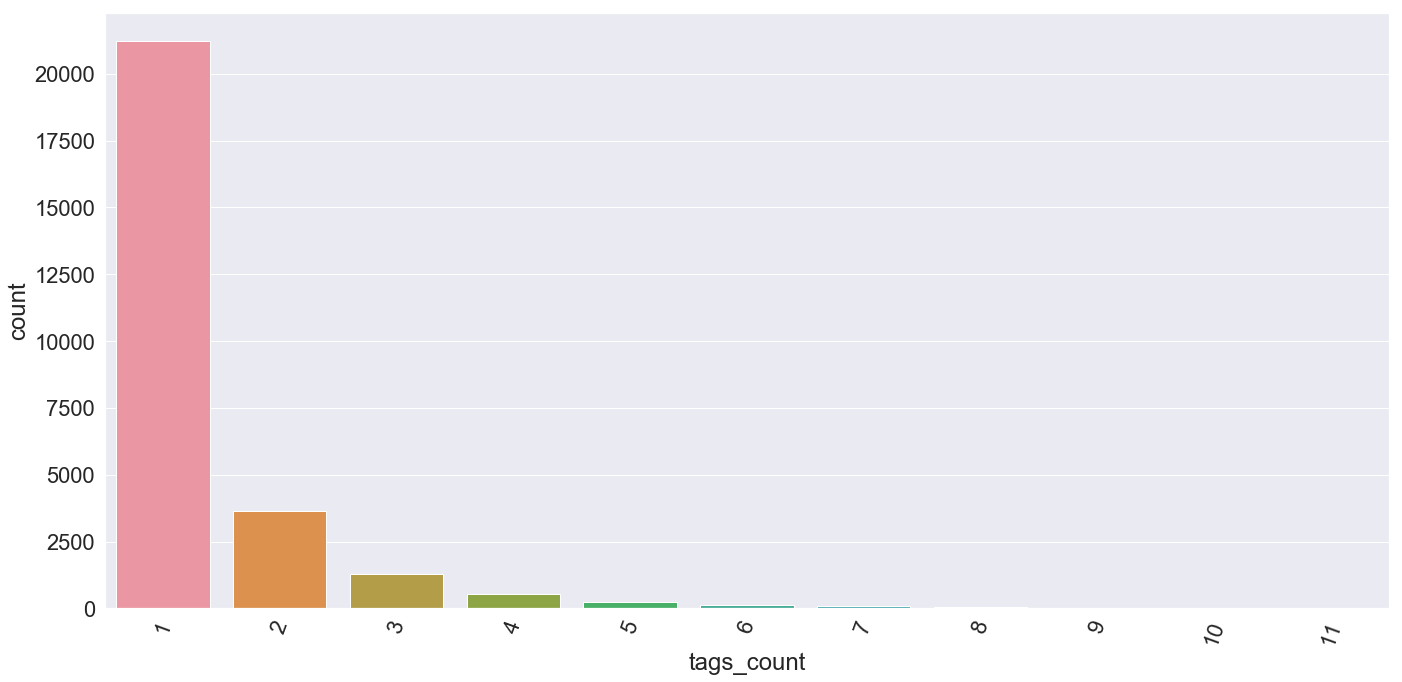

In [33]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('tags_count', data=tags_count_per_word_distribution)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

As we can see the majority of words has only one tag.

But there are also others, let's look at them a bit closer:

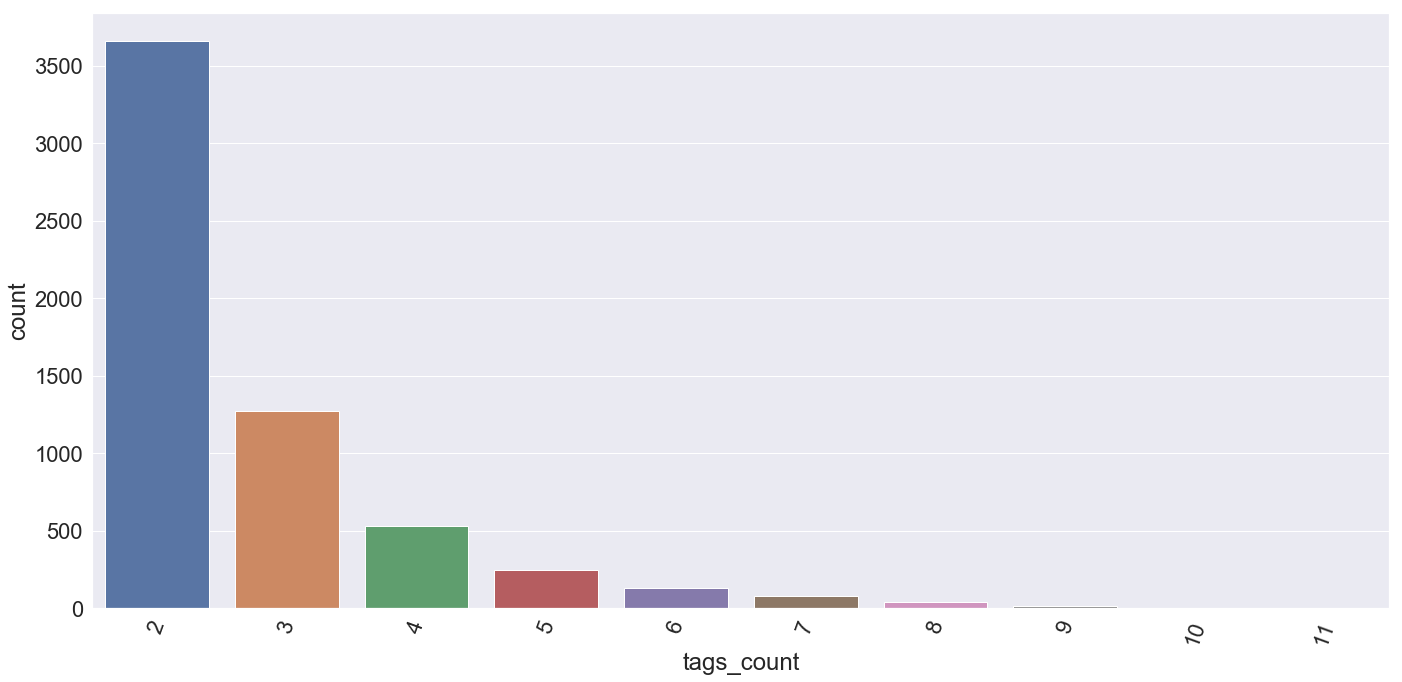

In [34]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('tags_count', data=tags_count_per_word_distribution[tags_count_per_word_distribution.tags_count != 1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

# Lemma length distribution

Let's lookt at how word lengths are distributed:

In [35]:
tagged_texts_as_pd['lemma_length'] = tagged_texts_as_pd.lemma.apply(len)

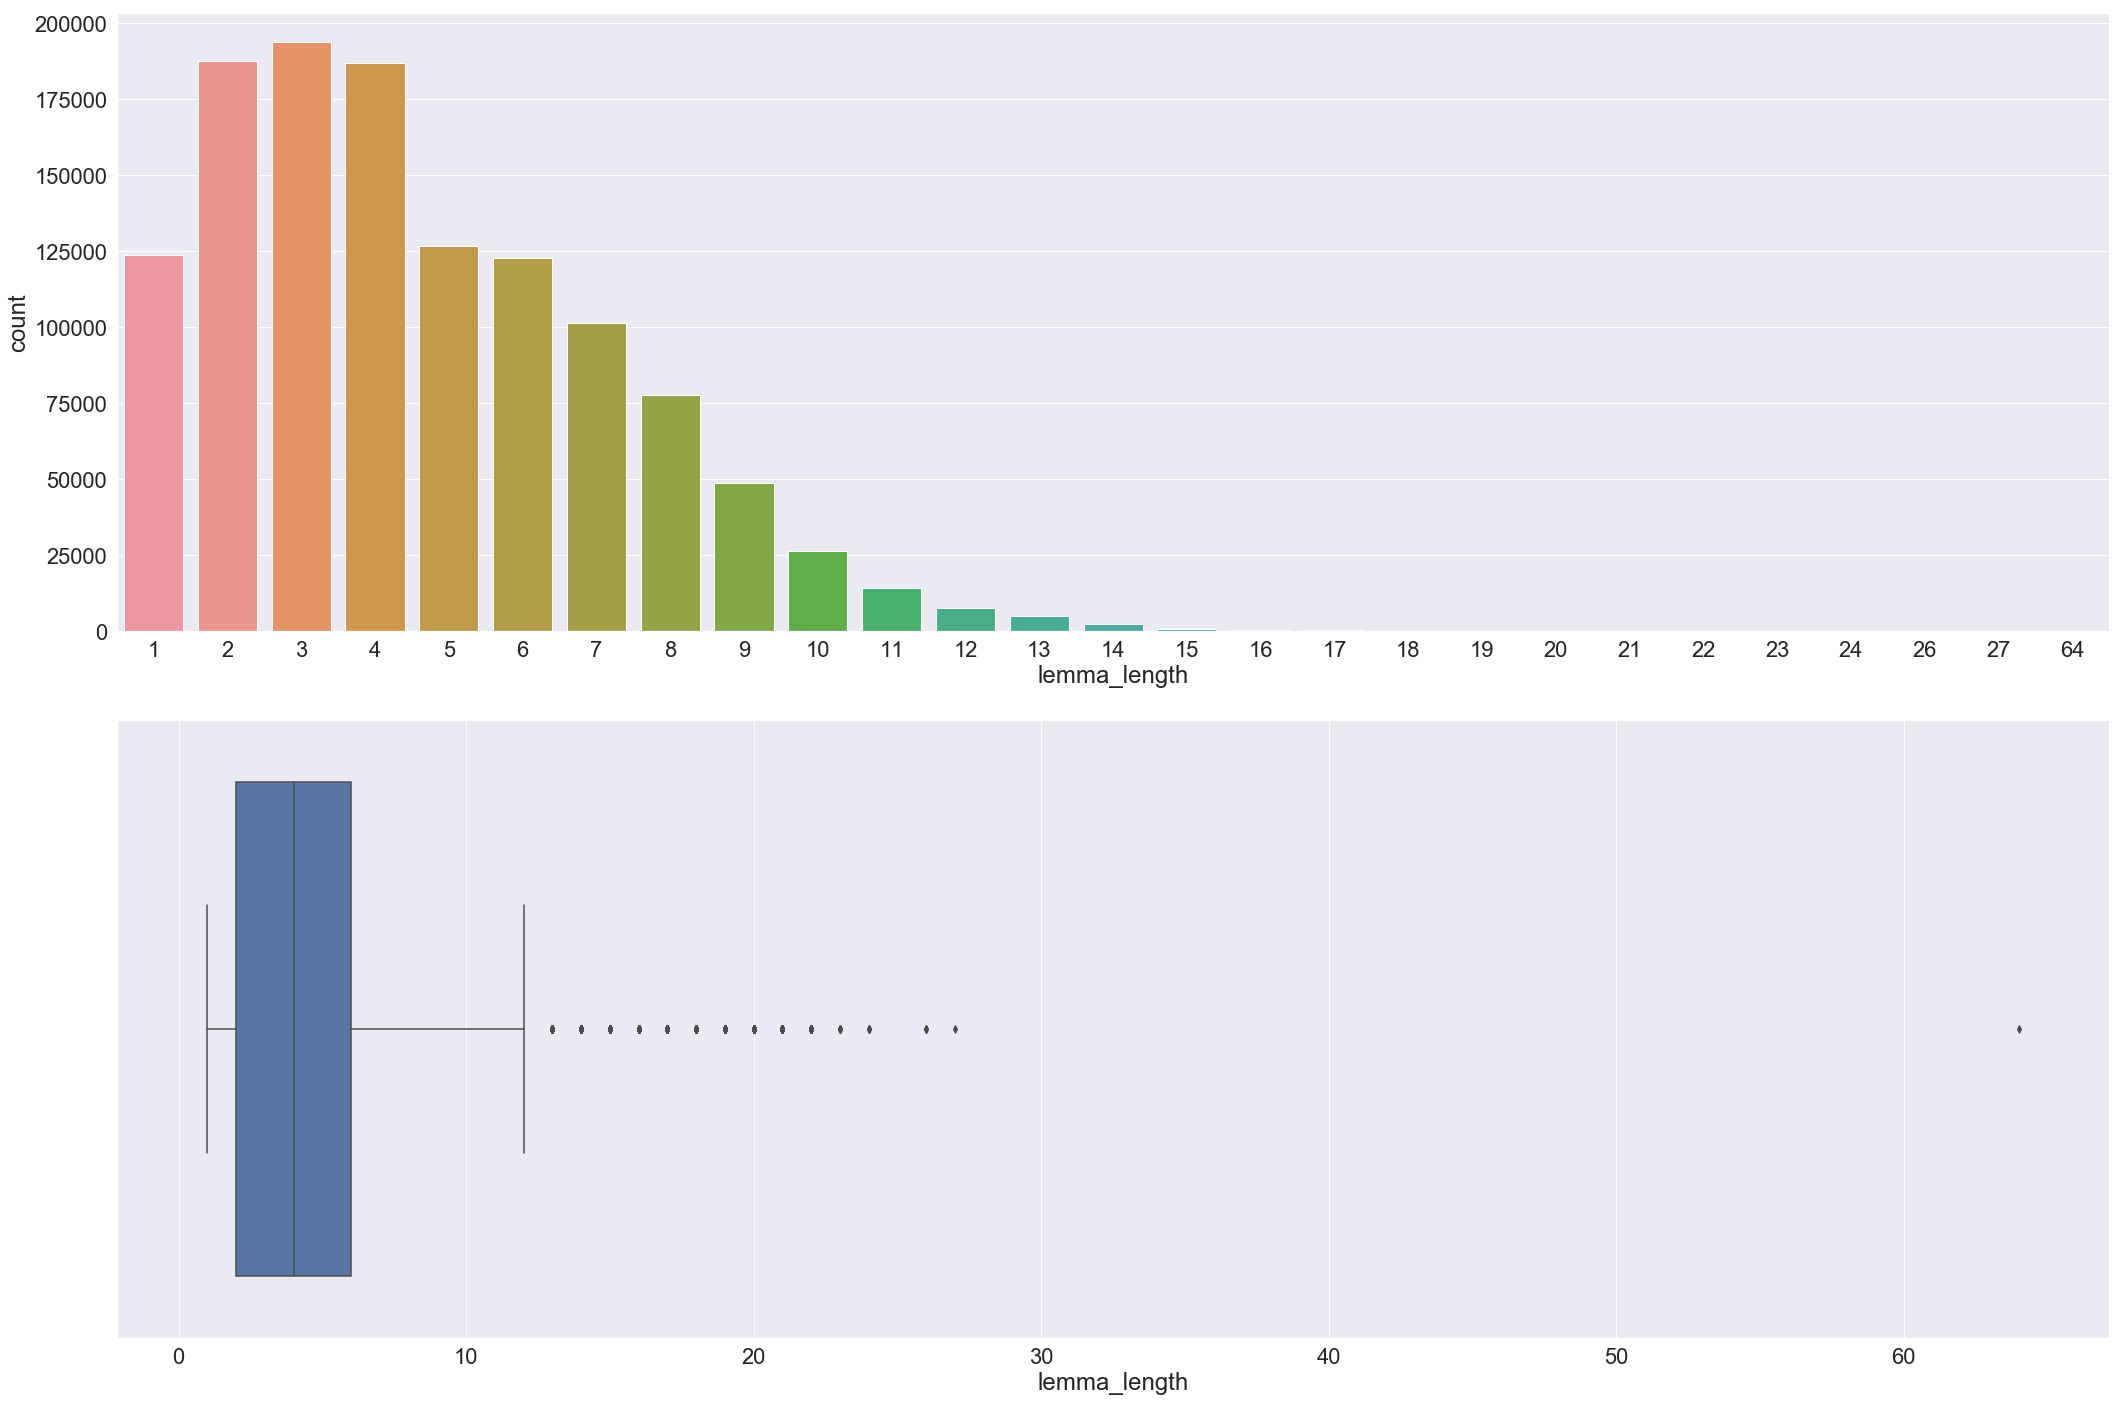

In [36]:
sns.set(font_scale=2)
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 20))
sns.countplot('lemma_length', data=tagged_texts_as_pd, ax=ax1)
sns.boxplot('lemma_length', data=tagged_texts_as_pd, ax=ax2, orient='h')
plt.tight_layout()
plt.show()

The main majority of words has length between 3 and 7 letters and there are obviously several outliers.

Let's look at them closer:

In [37]:
tagged_texts_as_pd.sort_values(by='lemma_length', ascending=False).head(30)

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr,lemma_length
181246,https://www.celebritiesforcharity.org/raffles/...,NNP,https://www.celebritiesforcharity.org/raffles/...,B-geo,0,[],O,Place,N,"lam(v1,b1:drs([],[b1:[2025]:named(v1,'https://...",64
145539,cricketer-turned-politician,JJ,cricketer-turned-politician,O,0,[Topic],O,O,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...",27
2895,internationally-recognized,JJ,internationally-recognized,O,0,[Topic],O,O,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...",26
912265,internationally-recognized,JJ,internationally-recognized,O,0,[Topic],O,O,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...",26
811960,internationally-recognized,JJ,internationally-recognized,O,0,[Topic],O,O,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...",26
491926,environmentally-friendly,RB,environmentally-friendly,O,0,[Topic],O,O,S[adj]\NP,"lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[...",24
238916,environmentally-friendly,JJ,environmentally-friendly,O,0,[Topic],O,O,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...",24
216726,internationally-brokered,JJ,internationally-brokered,O,0,[Topic],O,O,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...",24
192280,Petropavlosk-Kamchatskii,NNP,petropavlosk-kamchatskii,B-geo,0,[],O,Place,N,"lam(v1,b1:drs([],[b1:[2028]:named(v1,'petropav...",24
438133,Congressional-Executive,JJ,congressional-executive,B-org,0,[Topic],O,Organization,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...",23


Ok, and how do short words look like?

In [38]:
tagged_texts_as_pd.sort_values(by='lemma_length', ascending=True).head(60)

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr,lemma_length
1231278,.,.,.,O,0,[],O,O,S[dcl]\S[dcl],"lam(v1,v1)",1
1022432,",",",",",",O,0,[],O,O,(S[pss]\NP)\(S[pss]\NP),"lam(v1,v1)",1
318994,.,.,.,O,0,[],O,O,S[dcl]\S[dcl],"lam(v1,v1)",1
1022420,.,.,.,O,0,[],O,O,S[dcl]\S[dcl],"lam(v1,v1)",1
319026,',POS,',O,0,[],of,O,(NP/N)\NP,"lam(v1,lam(v2,lam(v3,app(v1,lam(v4,alfa(def,me...",1
319029,a,DT,a,O,0,[],O,O,NP/N,"lam(v1,lam(v2,merge(b1:drs([b1:[3035]:x1],[]),...",1
319032,.,.,.,O,0,[],O,O,S[dcl]\S[dcl],"lam(v1,v1)",1
319041,.,.,.,O,0,[],O,O,S[dcl]\S[dcl],"lam(v1,v1)",1
1022379,.,.,.,O,0,[],O,O,S[dcl]\S[dcl],"lam(v1,v1)",1
1022375,",",",",",",O,0,[],O,O,N/N,"lam(v1,v1)",1


Well there are obviously lots of stop-words which will bring some noise in the data.



# Stop-words and punctuation

In [39]:
from nltk.corpus import stopwords

In [40]:
stopWords = set(stopwords.words('english'))

In [41]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

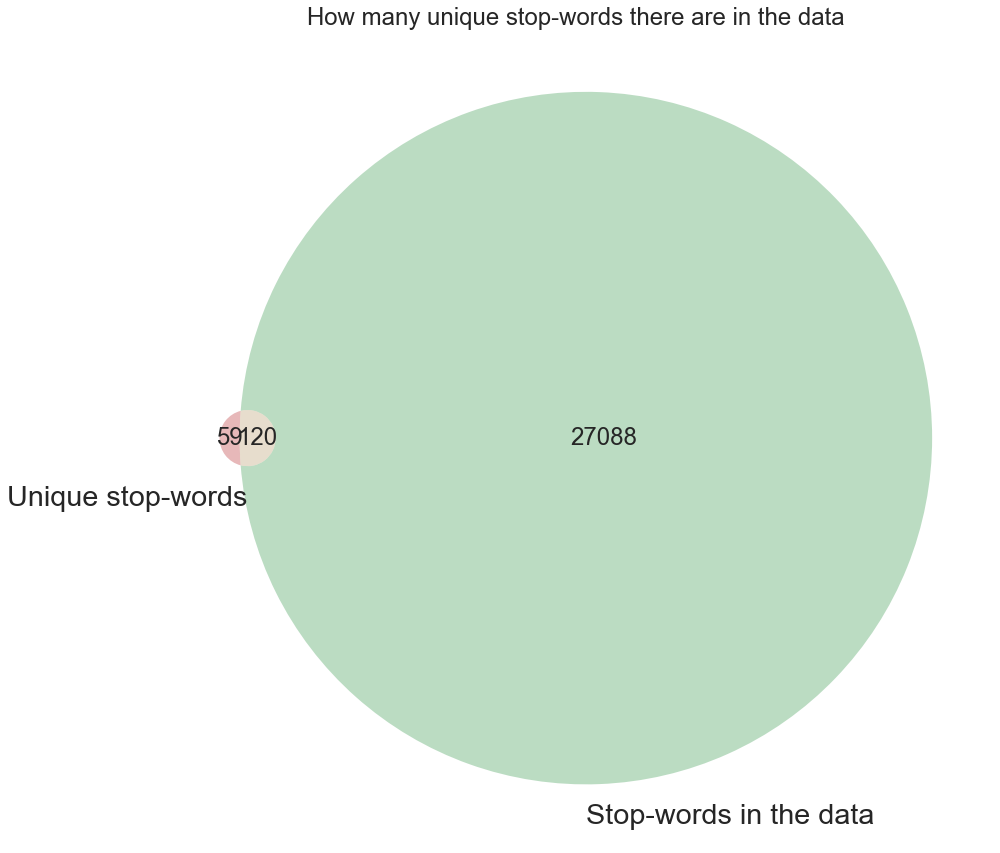

In [42]:
plt.figure(figsize=(15, 15))
venn2(subsets=[stopWords, set(tagged_texts_as_pd.lemma)], set_labels=('Unique stop-words', 'Stop-words in the data'))
plt.title('How many unique stop-words there are in the data')
plt.show()

Let's remove them and see if the NER-tag distribution will change:

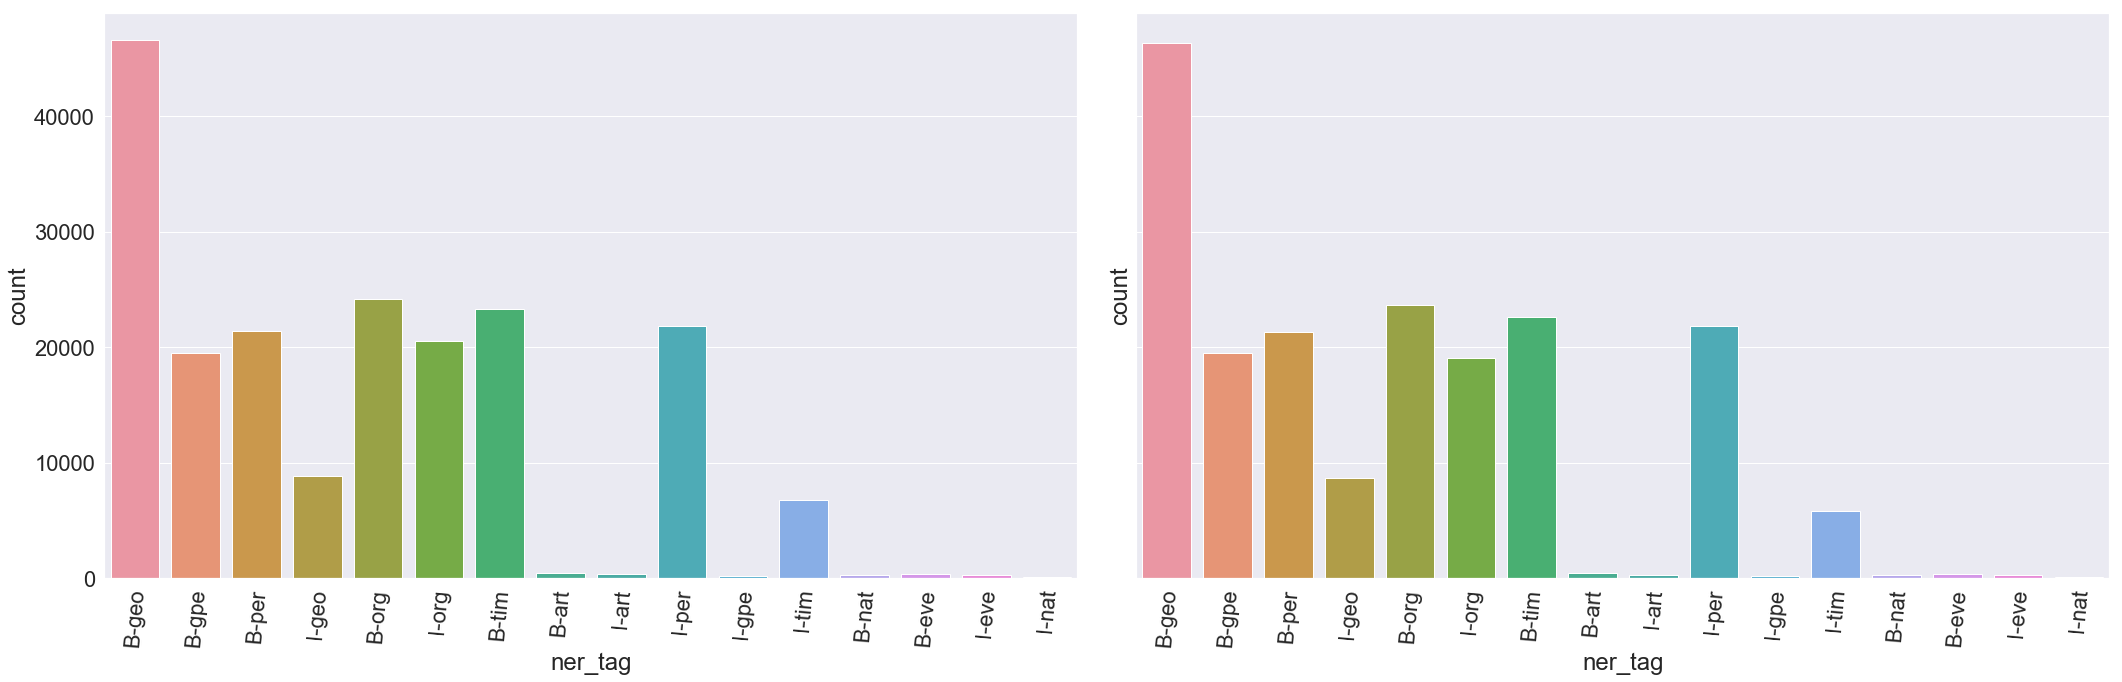

In [48]:
sns.set(font_scale=2)
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True)
sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'], ax=ax1)
sns.countplot('ner_tag', data=tagged_texts_as_pd[(~tagged_texts_as_pd.lemma.isin(stopWords)) & (tagged_texts_as_pd.ner_tag != 'O')], ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=85, ha="center")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=85, ha="center")
plt.tight_layout()
plt.show()

We can see from these plots that the distribution has not dramatically changed.

How many words were deleted?

In [49]:
len(tagged_texts_as_pd) - len(tagged_texts_as_pd[(~tagged_texts_as_pd.lemma.isin(stopWords))])

406955

Wow!

So many words were deleted and yet the distribution of NER-tags stayed almost the same.

Looks like it was mostly "O"-tags (surprise-surprise, who would have thought!)))

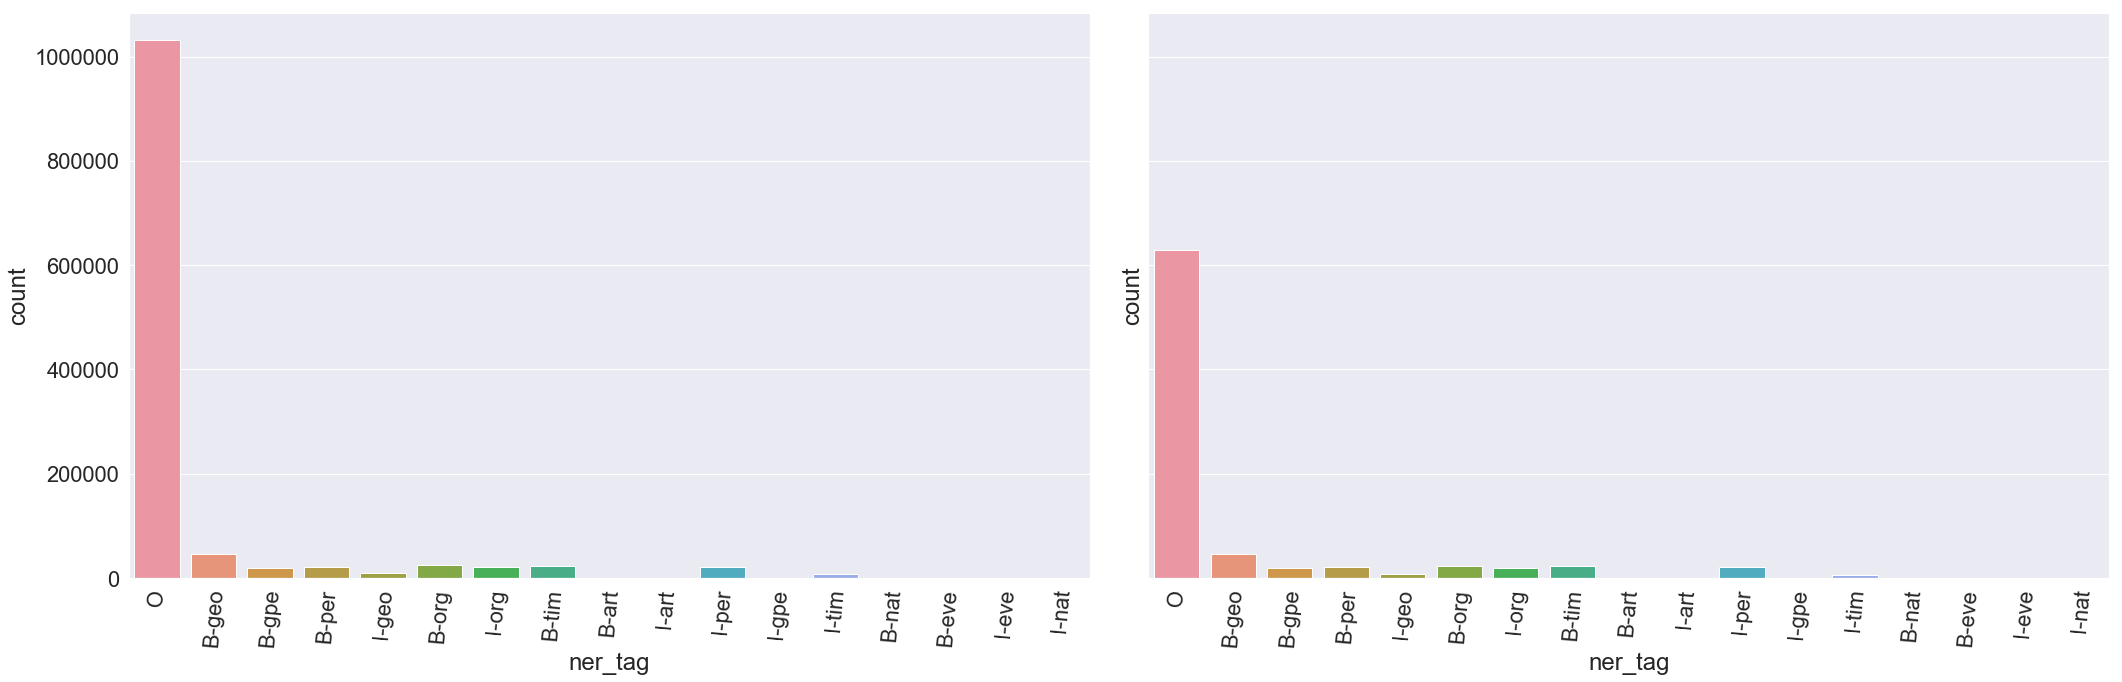

In [50]:
sns.set(font_scale=2)
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True)
sns.countplot('ner_tag', data=tagged_texts_as_pd, ax=ax1)
sns.countplot('ner_tag', data=tagged_texts_as_pd[~tagged_texts_as_pd.lemma.isin(stopWords)], ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=85, ha="center")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=85, ha="center")
plt.tight_layout()
plt.show()

And yep, it was mostly "O"-tags which can be seen from the difference in the two first columns of the plots.

# Token shape

Let's introduce new feature - word shape.

Here is the method to calculate it:

In [51]:
def wordshape(word):
    import re
    t1 = re.sub('[A-Z]', 'X', word)
    t2 = re.sub('[a-z]', 'x', t1)
    t3 = re.sub('[0-9]', 'd', t2)
    t4 = re.sub(string.punctuation, 'p', t3)
    return t4

In [52]:
tagged_texts_as_pd['word_shape'] = tagged_texts_as_pd.token.apply(wordshape)

error: multiple repeat at position 10